# Main Causework UP2089158 UP2060325

## Import packages

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Settings & Load data

In [14]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # tf will show error messages only (reduce verbosity)
sns.set_style('white')

(X_train, y_train), (X_test, y_test) = cifar100.load_data()
print(X_train.shape, X_test.shape)

n_labels = len(np.unique(y_train))
n_labels

(50000, 32, 32, 3) (10000, 32, 32, 3)


100

## Workflow for data

array pointer = 60
x_train[60] shape: (32, 32, 3)
label: [36]


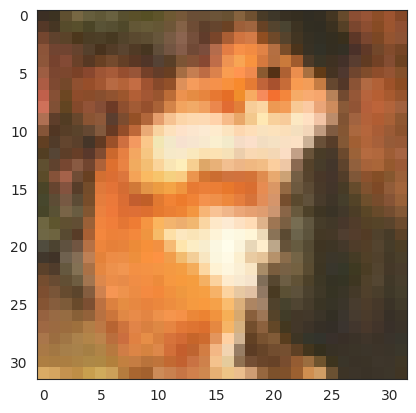

In [9]:
pointer = 60 # number of image in the dataset (remember, numbering starts from 0!)

print(f"array pointer = {pointer}")
print(f"x_train[{pointer}] shape: {X_train[pointer].shape}")
print(f"label: {y_train[pointer]}")

plt.imshow(X_train[pointer],cmap='Accent')
plt.show()

## Data preparation

In [ ]:
def check_images(dataset, dataset_name):
    """
    Checks images for:
    * being an array
    * shape (28x28)
    * colour channel values
    * NaN values
    """
    invalid_count = 0  # Counter for invalid images
    valid_count = 0     # Counter for valid images

    for idx, image in enumerate(dataset):
        # Check if the image is a NumPy array
        if not isinstance(image, np.ndarray):
            print(f"{dataset_name} - Index {idx}: Not a valid image array")
            invalid_count += 1
            continue

        # Check shape (should be 28x28)
        if image.shape != (28, 28):
            print(f"{dataset_name} - Index {idx}: Incorrect shape {image.shape}")
            invalid_count += 1
            continue

        # Check if values are within expected range (0-255 for grayscale images)
        if not (image.dtype == np.uint8 and image.min() >= 0 and image.max() <= 255):
            print(f"{dataset_name} - Index {idx}: Invalid pixel values (Min: {image.min()}, Max: {image.max()})")
            invalid_count += 1
            continue

        # Check for NaN values
        if np.isnan(image).any():
            print(f"{dataset_name} - Index {idx}: Contains NaN values")
            invalid_count += 1
            continue

        valid_count += 1

    print(f"\n{dataset_name}: {valid_count} valid images, {invalid_count} invalid images")

In [ ]:
# Run checks on both datasets
print("Checking Images...\n")
check_images(X_train, "Train")
check_images(X_test, "Test")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,
                                    y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)

## EDA

In [ ]:
# Define class names. CIFER 100 labels
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [ ]:
# Create a DataFrame for label frequency distribution
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

In [ ]:
def count_labels(dataset, dataset_name):
    """
    Helper function to count occurrences of each label and print them
    """
    global df_freq
    unique, counts = np.unique(dataset, return_counts=True)  # Get label frequencies
    for label, frequency in zip(unique, counts):
        df_freq = pd.concat([df_freq, pd.DataFrame([{'Set': dataset_name, 'Label': class_names[label], 'Frequency': frequency}])], ignore_index=True)
        print(f"* {dataset_name} - {class_names[label]}: {frequency} images")  # Print formatted output

In [ ]:
count_labels(y_train, "Train")
count_labels(y_test, "Test")
count_labels(y_val, "Validation")

In [ ]:
# Visualize the label distribution and save image
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.xticks(rotation=45)
plt.title("Label Frequency Distribution in Train, Validation, and Test Sets")
plt.show()

In [ ]:
# Current data shape:
X_train.shape

In [ ]:
# Reshape CIFER 100 data for CNN
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Check the new shape
print(X_train.shape)  # Expected output: (48000, 28, 28, 1)

In [ ]:
X_train.max()

In [ ]:
# **Convert labels to categorical format**
n_labels = 100  # CIFER 100 classes
y_train = to_categorical(y_train, num_classes=n_labels)
y_val = to_categorical(y_val, num_classes=n_labels)
y_test = to_categorical(y_test, num_classes=n_labels)

In [ ]:
y_test

# Building model

In [ ]:
def build_tf_model(input_shape, n_labels):
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(n_labels, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
model = build_tf_model(input_shape=X_train.shape[1:], n_labels=n_labels )
model.summary()

# Fit the model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

In [ ]:
model = build_tf_model(input_shape= X_train.shape[1:], n_labels=n_labels )

model.fit(x=X_train,
          y=y_train,
          epochs=4,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[early_stop]
          )

## building model

In [ ]:
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))  # 100 Classes

# Compile the Model
model.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model.summary()
